In [ ]:
!pip install ruptures

     |████████████████████████████████| 991 kB 5.2 MB/s 


In [ ]:
import datetime as dt
from math import log

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
from matplotlib.dates import DateFormatter
from ruptures.base import BaseCost
from ruptures.metrics import hausdorff
from scipy.stats import ttest_ind
from scipy.optimize import minimize, root
from tqdm import tqdm
from time import time

In [ ]:
from numba import jit

## R-FPOP implementation

We implemented a heap structure to efficiently store, read and write the piecewise quadratic writing of the cost objective.

A quadratic function $q_i$ is coded by an object `Node` defined by its `start` and `end` points and its coefficients `[a2,a1,a0]` such that $q_i(\theta)=a_2 \theta^2 + a_1\theta + a_0$.

It also has a `child` and a `father` field which verify : `self.end==self.child.start` and `self.start==self.father.end`.

We define the methods `split` and `merge` to modify the elements of the heap, while keeping its structure consistent.

In [ ]:
class Node():
    def __init__(self, start, end, coeffs: np.ndarray, change_point=None):
        self.start = start # start of the interval
        self.end = end # end of the interval
        self.coeffs = coeffs # [a2, a1, a0]
        self.change_point = change_point
        self.child = None
        self.father = None

    def func(self, theta):
        return (self.coeffs * theta ** np.arange(2,-1,-1)).reshape(-1,3).sum(axis=1)

    def set_child(self, ChildNode):
        self.child = ChildNode
        ChildNode.father = self

    def set_father(self, FatherNode):
        self.father = FatherNode
        FatherNode.child = self

    def merge(self):
        '''merge a Node with its child'''
        self.end = self.child.end
        if self.change_point!=self.child.change_point:
            print('Trying to merge while change points are the same')
            raise RuntimeError
        self.child = self.child.child # WARNING memory leak --> need to delete the intermediate node

    def split(self, mid, coeffs, after=True):
        # change_point?
        if after:
            # new coeffs after mid
            new = Node(mid, self.end, coeffs)
        else:
            # new coeffs before mid
            new = Node(mid, self.end, self.coeffs)
            self.coeffs = coeffs
        self.end = mid
        new.set_child(self.child)
        self.set_child(new)

class CustomHeap():
    def __init__(self, start, end, coeffs, change_point=None):
        self.root = Node(start, end, coeffs, change_point)

    def simplify(self):
        current_node = self.root
        while current_node!=None and current_node.child!=None:
            if (current_node.coeffs==current_node.child.coeffs).all():
                current_node.merge()
            current_node = current_node.child

    def plot(self):
        current_node = self.root
        while current_node!=None:
            x = np.linspace(current_node.start, current_node.end, 100)
            plt.plot(x,current_node.func(x.reshape(-1,1)))
            #plt.axvline(current_node.start)
            current_node = current_node.child
        plt.show()

In [ ]:
def compute_Q_theta(Q_star: CustomHeap, Gamma: CustomHeap):
    current_node_qstar = Q_star.root
    current_node_gamma = Gamma.root
    define_root = True
    
    while current_node_qstar!=None and current_node_gamma!=None:
        start = max(current_node_qstar.start, current_node_gamma.start)
        end = min(current_node_qstar.end, current_node_gamma.end)

        if define_root:
            Q_theta = CustomHeap(
                start,
                end,
                current_node_qstar.coeffs+current_node_gamma.coeffs,
                current_node_qstar.change_point
            )
            current_node_q = Q_theta.root
            define_root = False
        else:
            current_node_q.set_child(Node(
                start,
                end,
                current_node_qstar.coeffs+current_node_gamma.coeffs,
                current_node_qstar.change_point
            ))
            current_node_q = current_node_q.child
        
        if current_node_qstar.end == current_node_q.end:
            current_node_qstar = current_node_qstar.child
        else:
            current_node_gamma = current_node_gamma.child

    return Q_theta


def min_best_change(Q_theta: CustomHeap):
    current_node_q = Q_theta.root
    Q = np.inf
    tau_t = 0
    while current_node_q!=None:
        m = minimize(
            current_node_q.func,
            current_node_q.start,
            bounds=((current_node_q.start, current_node_q.end),)
        ).fun[0]
        if m < Q:
            Q = m
            tau_t = current_node_q.change_point
        current_node_q = current_node_q.child
    return (Q, tau_t)

def compute_Q_star(Q_theta: CustomHeap, C, t):
    eps = 1e-3 # to avoid numeric approximation errors
    current_node_q = Q_theta.root
    define_root = True
    while current_node_q!=None:
        R_tmp = np.roots(current_node_q.coeffs - np.array([0,0,C]))
        R_tmp.sort()
        R = [current_node_q.start]
        for root in R_tmp:
            if root > current_node_q.start + eps and root < current_node_q.end - eps and not np.iscomplex(root):
                R.append(root)
        R.append(current_node_q.end)
        for j in range(len(R)-1):
            start = R[j]
            end = R[j+1]
            # on this interval, Q_t(theta) has a constant sign
            if current_node_q.func((start+end)/2) > C:
                coeffs = np.array([0,0,C])
                change_point = t
            else:
                coeffs = current_node_q.coeffs.copy()
                change_point = current_node_q.change_point
            
            if define_root:
                Q_star = CustomHeap(
                    start,
                    end,
                    coeffs,
                    change_point
                )
                current_node_q_star = Q_star.root
                define_root = False
            else:
                current_node_q_star.set_child(Node(
                    start,
                    end,
                    coeffs,
                    change_point
                ))
                current_node_q_star = current_node_q_star.child
        current_node_q = current_node_q.child
    return Q_star

In [ ]:
def rfpop(signal, pen, thresh):
    n = signal.shape[0]
    Q_star = CustomHeap(
        signal.min(),
        signal.max(),
        coeffs = np.zeros(3)
    )
    change_points = []
    for t in tqdm(range(n)):
        # compute gamma(y_t, theta)
        # \theta**2 - 2*y_t*\theta + y_t**2
        R_tmp = np.roots(np.array([1,-2*signal[t],signal[t]**2]) - np.array([0,0,thresh**2]))
        R_tmp.sort()
        R = [signal.min()]
        for root in R_tmp:
            if root > signal.min() and root < signal.max() and root==np.real(root):
                R.append(root)
        R.append([signal.max()])
        for idx in range(len(R)-1):
            if (signal[t] - (R[idx]+R[idx+1])/2)**2 < thresh**2:
                coeffs = np.array([1,-2*signal[t],signal[t]**2])
            else:
                coeffs = np.array([0,0,thresh**2])
            if not idx:
                Gamma = CustomHeap(
                    R[idx],
                    R[idx+1],
                    coeffs
                )
                current_node_gamma = Gamma.root
            else:
                current_node_gamma.set_child(Node(
                    R[idx],
                    R[idx+1],
                    coeffs
                ))
                current_node_gamma = current_node_gamma.child
        #Gamma.plot()
        Q_theta = compute_Q_theta(Q_star, Gamma)
        Q, tau = min_best_change(Q_theta)
        change_points.append((Q,tau))
        Q_star = compute_Q_star(Q_theta,Q+pen, t)
        Q_star.simplify()
        # Q_theta.plot()
        # Q_star.plot()
    return change_points, Q_theta, Q_star

## Artifical outliers

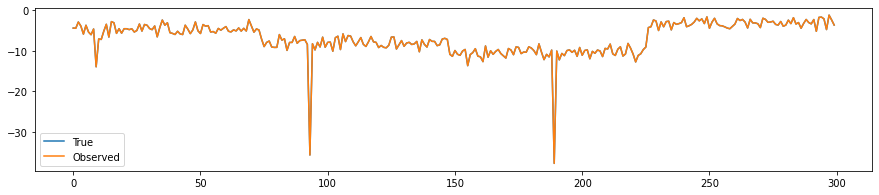

In [ ]:
# generate signal
n_samples = 300
n_bkps = 3
n_dims = 1
noise_std = 1
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal = signal + np.random.normal(
    scale=noise_std, size=signal.shape
)

n_outliers = int(n_samples * 0.01) # turn 1% of the points into potential outliers
idx = np.random.choice(n_samples, n_outliers, replace=False)
signal[idx] *= 4

fig, ax = fig_ax()
ax.plot(signal, label="True")
ax.plot(signal, label="Observed")
_ = plt.legend()

error: 65.0 samples


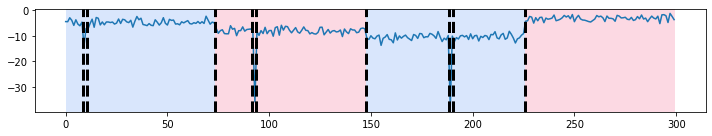

In [ ]:
pen_bic = 2 * np.log(n_samples) * noise_std**2 
predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(
    signal=signal, pen=pen_bic
)

fig, ax_arr = rpt.display(signal, bkps, predicted_bkps)
print(f"error: {hausdorff(bkps, predicted_bkps)} samples")

We need to choose K so that the two mild conditions are verified.

 - $M(\theta)$ has a positive second derivative for all $\theta$ in
a neighbourhood around 0 and that $M(\theta) - M(0) \geq c2 > 0$ for all $\theta$ outside this region
 - It is sufficient to choose $K$ such that $K>\sqrt{3} \mathbb{E}(Z_i^2)$

In [ ]:
class BiweightCost(BaseCost):

    """Biweight cost"""

    # The 2 following attributes must be specified for compatibility.
    model = "Biweight"
    

    def __init__(self, thresh):
        """Initialize the object."""
        self.signal = None
        self.min_size = 2
        self.thresh = thresh

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        return self

    def error(self, start, end):
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        sub = self.signal[start:end]
        l2_dist = sub.var(axis=0) * (end-start)
        constant = np.ones(sub.shape) * self.thresh**2
        mask = (l2_dist > self.thresh**2).astype(int)
        return (mask*constant + (1-mask)*l2_dist).mean()

error: 151.0 samples


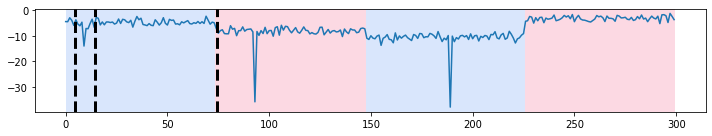

In [ ]:
pen_bic = 2 * np.log(n_samples) * noise_std**2 
predicted_bkps = rpt.Pelt(custom_cost=BiweightCost(19)).fit_predict(
    signal=signal, pen=pen_bic
)

fig, ax_arr = rpt.display(signal, bkps, predicted_bkps)
print(f"error: {hausdorff(bkps, predicted_bkps)} samples")

  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
100%|██████████| 300/300 [00:02<00:00, 119.20it/s]


error: 1.0 samples


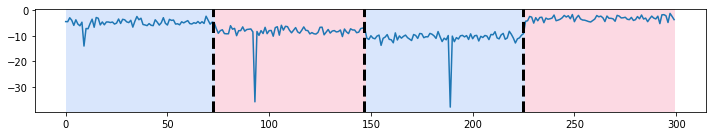

In [ ]:
cp, q_theta, q_star = rfpop(signal, 100, 3)

cp = np.array(cp)[:,1]
cp[np.where(cp == None)] = 0
predicted_bkps = np.unique(cp)[1:]
predicted_bkps = np.hstack((predicted_bkps,signal.shape[0]))

fig, ax_arr = rpt.display(signal, bkps, predicted_bkps)
print(f"error: {hausdorff(bkps, predicted_bkps)} samples")

## Well-log dataset

We consider the well-log dataset which contains 4050 values of the magnetic response of rock measured by a probe, as the ground is being drilled. The objective is to detect  the different strata in the rock.

The dataset is available on https://github.com/alan-turing-institute/rbocpdms/tree/master/Data.

In [ ]:
!gdown --id 189Zaj1-1L4Qq2kUgq6iFKAztCSR6U0Fb

Downloading...
From: https://drive.google.com/uc?id=189Zaj1-1L4Qq2kUgq6iFKAztCSR6U0Fb
To: /content/well.txt
100% 56.7k/56.7k [00:00<00:00, 51.2MB/s]


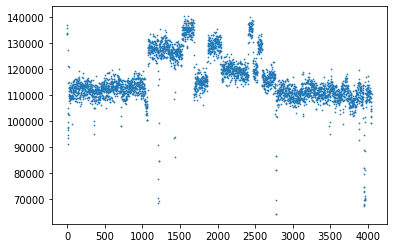

In [ ]:
well_log = np.array(open('well.txt').readlines()).astype(float)
plt.scatter(np.arange(4050), well_log, s=0.5)

In [ ]:
var = np.array([well_log[i+1]-well_log[i] for i in range(4049)]).var()

In [ ]:
cp, q_theta, q_star = rfpop(well_log, var*70, 3*np.sqrt(var))

100%|██████████| 4050/4050 [00:28<00:00, 141.75it/s]


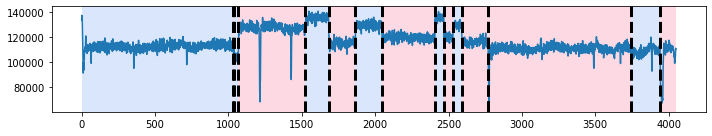

In [ ]:
cp = np.array(cp)[:,1]
cp[np.where(cp == None)] = 0
predicted_bkps = np.unique(cp)[1:]
predicted_bkps = np.hstack((predicted_bkps,well_log.shape[0]))

fig, ax_arr = rpt.display(well_log, predicted_bkps, predicted_bkps)

computed in 4.495269536972046


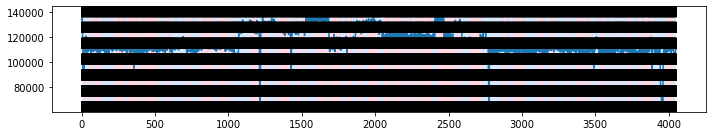

In [ ]:
pen_bic = 2 * np.log(4050) * noise_std**2 
start = time()
predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(
    signal=well_log, pen=pen_bic
)
print('computed in {}'.format(time()-start))
fig, ax_arr = rpt.display(well_log, predicted_bkps, predicted_bkps)